# QuickDraw CNN 

Goal : From pictures of Quickdraw , find the best CNN model to predict from which categories the draw come from

dateset from : https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap;tab=objects?pli=1&prefix=&forceOnObjectsSortingFiltering=false

## Import Librairies

In [1]:


import tensorflow as tf
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os



In [2]:
assert hasattr(tf, "function") # check tensorflow

## Data Preparation

### Load

In [3]:

dataset_dir = "quick_draw_dataset"
files = [name for name in os.listdir(dataset_dir) if ".npy" in name]
max_size_per_cl = 1500
draw_class = []

# Evaluate the size of the dataset
size = 0
for name in files:
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 1500 draw
    size += draws.shape[0]

images = np.zeros((size, 28, 28))
targets = np.zeros((size,))

it = 0
t = 0
for name in files:
    # Open each dataset and add the new class
    draw_class.append(name.replace("full_numpy_bitmap_", "").replace(".npy", ""))
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 1500 draw
    # Add images to the buffer
    images[it:it+draws.shape[0]] = np.invert(draws.reshape(-1, 28, 28))
    targets[it:it+draws.shape[0]] = t
    # Iter
    it += draws.shape[0]
    t += 1

images = images.astype(np.float32)

# Shuffle dataset
indexes = np.arange(size)
np.random.shuffle(indexes)
images = images[indexes]
targets = targets[indexes]


# Split into train and validation sets
if size >= 3:
    images_train, images_valid, targets_train, targets_valid = train_test_split(images, targets, train_size=0.6, test_size=0.2)
else:
    print("Error: not enough samples to split into train and validation sets")
    exit(1)

print("images_train.shape", images_train.shape)
print("targets_train.shape", targets_train.shape)

print("images_valid.shape", images_valid.shape)
print("targets_valid.shape", targets_valid.shape)

print(draw_class)



images_train.shape (8100, 28, 28)
targets_train.shape (8100,)
images_valid.shape (2700, 28, 28)
targets_valid.shape (2700,)
['apple', 'book', 'brain', 'car', 'cat', 'dog', 'dragon', 'horse', 'lollipop']


## check a picture

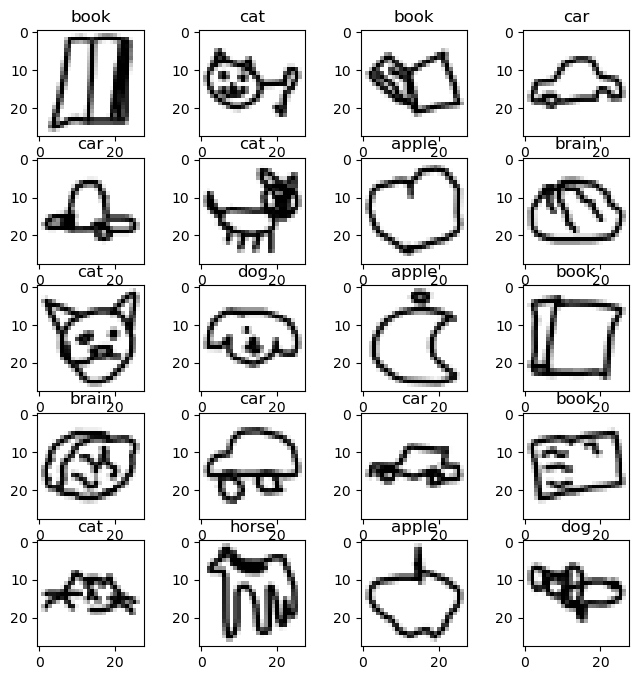

In [4]:


w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    index = np.random.randint(len(images))
    img = images[index]
    fig.add_subplot(rows, columns, i)
    plt.title(draw_class[int(targets[index])]) 
    plt.imshow(img, cmap="gray")
plt.show()


## Normalization of the data

In [5]:
print("Mean and std of images", images.mean(), images.std())
scaler = StandardScaler()
scaled_images = scaler.fit_transform(images.reshape(-1, 28*28))
scaled_images_valid = scaler.transform(images_valid.reshape(-1, 28*28))
print("Mean and std of scaled images", scaled_images.mean(), scaled_images.std())

scaled_images = scaled_images.reshape(-1, 28, 28, 1)
scaled_images_valid = scaled_images_valid.reshape(-1, 28, 28, 1)

Mean and std of images 208.62094 86.1588
Mean and std of scaled images -1.686771e-09 0.9285713


In [6]:
scaler = StandardScaler()

# Scale training images and labels
scaled_images = scaler.fit_transform(images.reshape(-1, 28*28))
scaled_images = scaled_images.reshape(-1, 28, 28, 1)
scaled_data = []
for i in range(len(scaled_images)):
    scaled_data.append((scaled_images[i], targets[i]))

# Scale validation images and labels
scaled_images_valid = scaler.transform(images_valid.reshape(-1, 28*28))
scaled_images_valid = scaled_images_valid.reshape(-1, 28, 28, 1)
scaled_data_valid = []
for i in range(len(scaled_images_valid)):
    scaled_data_valid.append((scaled_images_valid[i], targets_valid[i]))


## Handle dataset

In [7]:
def generator():
    for image, label in scaled_data:
        yield image, label

train_dataset = tf.data.Dataset.from_generator(
    generator, 
    output_signature=(
        tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
)

def valid_generator():
    for image, label in scaled_data_valid:
        yield image, label

valid_dataset = tf.data.Dataset.from_generator(
    valid_generator, 
    output_signature=(
        tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
)





## Build a model with the subclassing API

In [8]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        self.conv1 = tf.keras.layers.Conv2D(32, 4, activation='relu', name="conv1")
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', name="conv2")
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', name="conv3")
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(10, activation='softmax', name="output")

    def call(self, image):
        conv1 = self.conv1(image)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        flatten = self.flatten(conv3)
        d1 = self.d1(flatten)
        output = self.out(d1)
        return output
'''
model = ConvModel()
model.predict(scaled_images[0:1])
'''

'\nmodel = ConvModel()\nmodel.predict(scaled_images[0:1])\n'

## Set the loss and objectives

In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

## Set some metrics to track the progress of the training

In [10]:
# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

## Training method

The train_step method used autograp, compute the gradient to optimize the model and gather the loss and accuracy on the training set

In [11]:
@tf.function
def train_step(image, targets):
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(image)
        # Get the error/loss on these predictions
        loss = loss_object(targets, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(targets, predictions)

## Validation method

The valid_step function is simply used to test the image on the validation set and to gather the loss and accuracy

In [12]:
@tf.function
def valid_step(image, targets):
    predictions = model(image)
    t_loss = loss_object(targets, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(targets, predictions)

## Train and test the model on the validation set

In [13]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [14]:
epoch = 10
batch_size = 32
b = 0

best_valid_loss = float('inf')
best_valid_acc = 0
best_epoch = 0
with strategy.scope():
    model = ConvModel()
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )

for epoch in range(epoch):
    # Training set
    for images_batch, targets_batch in train_dataset.batch(batch_size):

        train_step(images_batch, targets_batch)
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(targets), train_loss.result(),
            train_accuracy.result()*100
        ), end="")
        b += batch_size
    # Validation set
    for images_batch, targets_batch in valid_dataset.batch(batch_size):
        valid_step(images_batch, targets_batch)
        valid_loss_value = valid_loss.result()
        valid_acc_value = valid_accuracy.result()
    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(),
        valid_accuracy.result()*100)
    )

    if valid_loss_value < best_valid_loss:
        best_valid_loss = valid_loss_value
        best_epoch = epoch
    if valid_acc_value > best_valid_acc:
        best_valid_acc = valid_acc_value

    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()

    # Save the model weights if it improves on validation loss
checkpoint_callback.on_epoch_end(epoch, {'val_loss': valid_loss_value, 'val_accuracy': valid_acc_value})


 Batch 13472/13500, Loss: 0.7578607797622681, Accuracy: 75.07772979736328
Epoch 1, Valid Loss: 0.4507702589035034, Valid Accuracy: 84.44444274902344
 Batch 26976/13500, Loss: 0.4077703058719635, Accuracy: 86.185188293457032
Epoch 2, Valid Loss: 0.34274280071258545, Valid Accuracy: 87.77777862548828
 Batch 40480/13500, Loss: 0.22275890409946442, Accuracy: 92.16296386718759
Epoch 3, Valid Loss: 0.19847701489925385, Valid Accuracy: 92.81481170654297
 Batch 53984/13500, Loss: 0.12240450829267502, Accuracy: 95.68148040771484
Epoch 4, Valid Loss: 0.21271120011806488, Valid Accuracy: 92.96295928955078
 Batch 67488/13500, Loss: 0.07681699097156525, Accuracy: 97.27407836914062
Epoch 5, Valid Loss: 0.10137361288070679, Valid Accuracy: 96.88888549804688
 Batch 80992/13500, Loss: 0.058046285063028336, Accuracy: 98.06666564941406
Epoch 6, Valid Loss: 0.04760081321001053, Valid Accuracy: 98.44444274902344
 Batch 94496/13500, Loss: 0.03973774611949921, Accuracy: 98.555549621582036
Epoch 7, Valid Loss

AttributeError: 'NoneType' object has no attribute 'distribute_strategy'

In [ ]:
'''
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(train_dataset, epochs=10, validation_data=valid_dataset, callbacks=[early_stopping])
'''

In [15]:


prediction = model.predict(scaled_images[0:1])
print(prediction)

1/1 [==============================] - 0s 331ms/step
[[1.3027334e-09 1.0000000e+00 1.2441979e-14 3.1543798e-12 3.8610961e-17
  6.4803645e-14 3.4689496e-09 1.8070646e-18 7.0866429e-19 6.3951603e-22]]
